# Circular waveguide filter - Discussion

In [13]:
# Temporary 'hack' for working directory not coinciding with file directory
import os
os.chdir('/home/fenics/shared/examples/circular_waveguide_filter')

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [14]:
import time
import numpy as np
import matplotlib.pyplot as plt

import fenics as fen
from circular_waveguide_filter import CircularWaveguideFilter

from context import src
from src.vector_space import VectorSpaceL2
from src.minimal_rational_interpolation import MinimalRationalInterpolation
import src.helpers as helpers

### Dimensions and properties

In [15]:
# Dimensions in meters
Lc = 0.04387  # Length of the cavities
Ls = 0.00150  # Length of the slots
Lr = 0.02000  # Length of rectangular input/output WR75-waveguide
Hr = 0.009525 # Height of rectangular input/output WR75-waveguide
Wr = 0.01905  # Width of rectangular input/output WR75-waveguide

Dx = Ls/2 + Lc + Ls + Lr  # |x|-coordinate of input/output boundary
Dy = Wr/2  # |y|-limit of input/output boundary
Dz = Hr/2  # |z|-limit of input/output boundary

In [23]:
class B_N(fen.SubDomain):
    def inside(self, x, on_boundary):
        return on_boundary and fen.near(abs(x[0]), Dx) and x[1]>-Dy and x[1]<Dy and x[2]>-Dz and x[2]<Dz

class g_N_L(fen.UserExpression):
    def eval(self, value, x):
        value[0] = 0.0
        value[1] = 0.0
        value[2] = 1.0 / (4e-7*np.pi) if fen.near(x[0], -Dx) else 0.0
    def value_shape(self):
        return (3,)

class g_N_R(fen.UserExpression):
    def eval(self, value, x):
        value[0] = 0.0
        value[1] = 0.0
        value[2] = - 1.0 / (4e-7*np.pi) if fen.near(x[0], Dx) else 0.0
    def value_shape(self):
        return (3,)

mesh = os.getcwd() + '/model/DMCWF.xml'
CWF = CircularWaveguideFilter(mesh, B_N, g_N=[g_N_L(), g_N_R()])
VS = VectorSpaceL2(CWF)
CWF.setup()

### Solution of problem

/usr/lib/python3/dist-packages/numpy/core/numeric.py:531: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


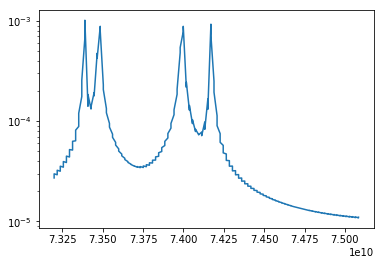

In [27]:
a = 2*np.pi*1.165e+10
b = 2*np.pi*1.195e+10
fig, ax = plt.subplots(figsize=(6, 4), sharex=True)
omegas = np.linspace(a, b, 100)
#CWF.solve(omegas, solver='fenics')
#CWF.save_solution('snapshots/linspace_1.165e+10_1.195e+10_100.obj')
#CWF.load_solution('snapshots/linspace_1.165e+10_1.195e+10_100.obj')
helpers.plot_solution_norms(ax, CWF, VS)

#### Analyzing scattering coefficients

In [46]:
def get_interpolatory_solutions(omega, CWF_L, CWF_R, VS):
    omega_test = np.linspace(np.min(omega), np.max(omega), 1000)
    MRI = MinimalRationalInterpolation(VS)
    MRI_L_hist = MRI.compute_surrogate(CWF_L, omegas=omega_test, greedy=True, tol=1e-2, solver='fenics', return_history=True)
    U_MRI_L = MRI.evaluate_surrogate(CWF_L.get_solution(), omega).T
    MRI_R_hist = MRI.compute_surrogate(CWF_R, omegas=omega_test, greedy=True, tol=1e-2, solver='fenics', return_history=True)
    U_MRI_R = MRI.evaluate_surrogate(CWF_R.get_solution(), omega).T
    U_MRI = np.empty((2*len(omega), U_MRI_R.shape[1]), dtype=complex)
    U_MRI[::2] = U_MRI_L
    U_MRI[1::2] = U_MRI_R
    return U_MRI, MRI_L_hist, MRI_R_hist

In [44]:
def compute_scattering_matrices(F, U, freq, freq_c=6.56e+9, freq_0=1e+10):
    N = len(freq) // 2
    S = [np.empty((2, 2), dtype=complex)] * N
    for n in range(N):
        S[n][0, 0] = np.inner(F[0], U[2*n])
        S[n][0, 1] = np.inner(F[1], U[2*n])
        S[n][1, 0] = np.inner(F[0], U[2*n+1])
        S[n][1, 1] = np.inner(F[1], U[2*n+1])
        S[n] *= 1j*freq[n]*np.sqrt((1 - (freq_c/freq_0)**2) / (1 - (freq_c / freq[n])**2))
        S[n] = np.eye(2) - 2 * np.linalg.inv(np.eye(2) + S[n])
    return S

In [36]:
def get_scattering_coefficients(S):
    S11 = np.abs(S)[:, 0, 0]
    S21 = np.abs(S)[:, 1, 0]
    S12 = np.abs(S)[:, 0, 1]
    S22 = np.abs(S)[:, 1, 1]
    return S11, S21, S12, S22

In [47]:
freq = CWF.get_frequency()

F = CWF.get_L(tonumpy=True) + CWF.get_N(tonumpy=True)
U_FEM = CWF.get_solution()

CWF_L = CircularWaveguideFilter(mesh, B_N, g_N=g_N_L())
CWF_L.setup()
CWF_R = CircularWaveguideFilter(mesh, B_N, g_N=g_N_R())
CWF_R.setup()
U_MRI, MRI_L_hist, MRI_R_hist = get_interpolatory_solutions(freq[::2], CWF_L, CWF_R, VS)

S_FEM = compute_scattering_matrices(F, U_FEM, freq)
S_MRI = compute_scattering_matrices(F, U_MRI, freq)

S11_FEM, S21_FEM, S12_FEM, S22_FEM = get_scattering_coefficients(S_FEM)
S11_MRI, S21_MRI, S12_MRI, S22_MRI = get_scattering_coefficients(S_MRI)

Iteration 2: 12.086277084467772
Iteration 3: 120.8164435233488
Iteration 4: 479.69542327614374
Iteration 5: 47.577562572782014
Iteration 6: 42.158641157140046
Iteration 7: 0.003290982260579348
Iteration 2: 50.802231432970075
Iteration 3: 1092.4754032836966
Iteration 4: 443.82004286850645
Iteration 5: 174.96040718555486
Iteration 6: 27.50959924017981
Iteration 7: 0.009374717692838134


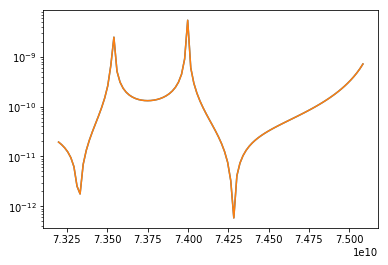

In [42]:
plt.plot(freq[::2], S12_FEM)
plt.plot(freq[::2], S12_MRI)
plt.yscale('log')

In [ ]:
fig, ax = plt.subplots(3, 1, figsize=(6, 4), sharex=True, gridspec_kw={'height_ratios': [10, 1]})

MRI = MinimalRationalInterpolation(VS)

for i in range(len(MRI_L_hist)):
    RI_L = MRI_L_hist[i]
    RI_R = MRI_R_hist[i]
    helpers.plot_surrogate_error_norms(ax[0], RC, MRI, VS, u_linspace, linspace, RI,
        label='S = {}'.format(i+2), color=cm(i/(n_iter-1)))
nodes = MRI.u_ring.get_nodes()
ax[1].scatter(nodes, np.zeros_like(nodes), s=10, c=cm(np.arange(len(nodes))/(n_iter-1)), zorder=-n_iter)
nodes = MRI.u_ring.get_nodes()
ax[2].scatter(nodes, np.zeros_like(nodes), s=10, c=cm(np.arange(len(nodes))/(n_iter-1)), zorder=-n_iter)
ax[0].set_ylabel('L\u2082 relative error')
ax[1].set_xlabel('Frequency \u03C9 (in rad/s)')
ax[1].set_xlim(a, b)
ax[1].set_yticks([])
ax[0].legend()
plt.subplots_adjust(wspace=0, hspace=0)

In [ ]:
S_FEM = compute_scattering_matrices(F, U_FEM, freq)
S_MRI = compute_scattering_matrices(F, U_MRI, freq)

S11_FEM, S21_FEM, S12_FEM, S22_FEM = get_scattering_coefficients(S_FEM)
S11_MRI, S21_MRI, S12_MRI, S22_MRI = get_scattering_coefficients(S_MRI)